In [1]:
%matplotlib inline
import numpy as np
from math import exp
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessary for 3D plotting
import matplotlib.cm as cm
from pylab import figure, plot, show, grid, axis, xlabel, ylabel, title, hold, draw
import seaborn as sns
from sympy import plot_implicit
from sklearn.metrics import mean_squared_error
sns.set_style('darkgrid')
import pandas as pd

#The Wiener process parameters.
C = np.array([[2, 1], [1, 1]]) #covariance matrix

# Total time.
T = 1

# Number of steps.
N = 1000

# Time step size
dt = T/N

def BrownianIncrements(C, N):
    """Brownian increments"""
    L = np.linalg.cholesky(C)
    DB = np.zeros((2, N))
    for j in range(N):
        DB[0, j] = np.random.normal(0, 1) / np.sqrt(N)
        DB[1, j] = np.random.normal(0, 1) / np.sqrt(N)
        DB[:, j] = L @ DB[:, j]
    # B = np.cumsum(DB, axis = 1)
    return DB
DB_T = BrownianIncrements(C, N)

#index activity 
index = [0.5, 0.8]

def StableIncrements(N):
    DX = np.zeros((N,2))
    Gamma = np.random.uniform(-0.5 * np.pi, 0.5 * np.pi, N)
    W = np.random.exponential(1, N)
    DX = [pow(dt, 1 / a) * (np.sin(a * Gamma))/ pow(np.cos(Gamma),1 / a)* \
                 pow((np.cos((1 - a) * Gamma)) / W, (1 - a) / a) for a in index]
    return DX
stable = StableIncrements(N)

def two_dim_jump_diffusion(ts, N, stable, DB_T):
    DX_F = np.zeros((2, N))
    DB_T = BrownianIncrements(C, N)
    stable = StableIncrements(N)
    DX = [sum(x) for x in zip(stable, DB_T)]
    DX_F = np.asarray(DX)
    return DX_F
DX_FA = two_dim_jump_diffusion(np.linspace(0, 1, N), N, stable, DB_T)

def phi_hat(u, DX):
    """Empirical characteristic function"""
    N = len(DX[0, :])
    dotproducts = np.zeros(N)
    for j in range(N):
        dotproducts[j] = np.inner(u, DX[:, j])
    return np.mean(np.exp(np.complex(0,1) * dotproducts))

#optimal choise of u_n parameter
u_N = np.array([np.sqrt(N), np.sqrt(N)])
u_N_tilde = np.array([np.sqrt(N), -np.sqrt(N)])

#spectral estimator for the covariance
C_hat = (N / (2 * u_N[0]**2)) * ((np.log(np.abs(phi_hat(u_N_tilde, DX_FA))) -
    np.log(np.abs(phi_hat(u_N, DX_FA)))))

In [3]:
# Monte carlo simulation
n = 1000

ts = np.linspace(0, 1, N)

C_hat = np.zeros(n)
for iteration in range(n):
    DX = two_dim_jump_diffusion(ts, N, stable, DB_T)
    C_hat[iteration] = (N / (2 * u_N[0]**2)) * ((np.log(np.abs(phi_hat(u_N_tilde, DX))) - np.log(np.abs(phi_hat(u_N, DX)))))

/Users/Kcantor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


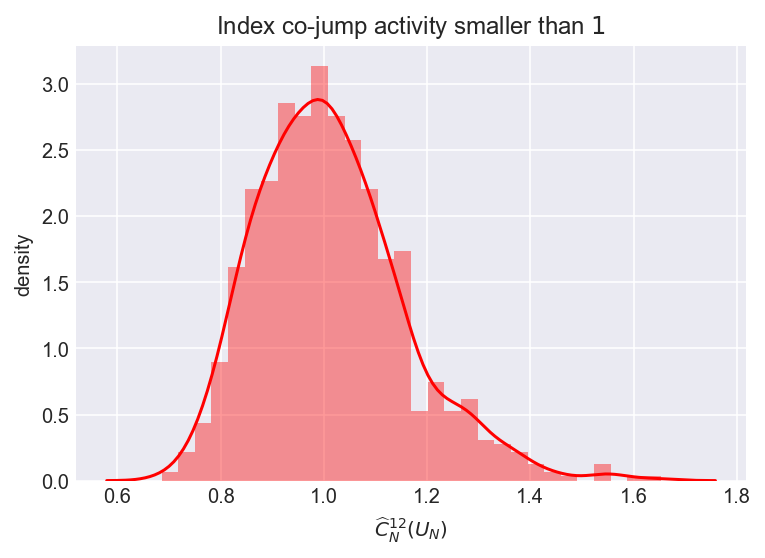

In [7]:
%config InlineBackend.figure_format = 'retina'
plt.savefig("histFA.png")
sns.distplot(C_hat, norm_hist = True, bins = 30, color = 'r')
title('Index co-jump activity smaller than $1$')
xlabel('$\widehat{C}_{N}^{12}({U}_{N})$')
ylabel('density')
plt.show()


In [4]:
vec = np.ones(n)
mean = mean_squared_error(C_hat, vec)
rmse = np.sqrt(mean)

In [7]:
# MC estimation for C_hat against different choices of our parameter U_N for finite variation jumps

#different choices of N
N = [x for x in range(1000, 10100, 1000)]

# preallocate the results in emply list
C_hat = [] 

#number of iterations
n = 1000
for j in N:
    for iter in range(n):
        DX = two_dim_jump_diffusion(np.linspace(0, 1, j), j, stable, DB_T)
        u_N = np.array([np.sqrt(j), np.sqrt(j)])
        u_N_tilde = np.array([np.sqrt(j), -np.sqrt(j)])
        C_hat.append((j / (2 * u_N[0]**2)) * ((np.log(np.abs(phi_hat(u_N_tilde, DX))) - np.log(np.abs(phi_hat(u_N, DX))))))

#split the data of C_hat in N arrays of size (1, n) each, i.e. for each choise of N print C_hat for n times MC.
C_hat_data = [C_hat[x : x + n] for x in range(0, len(C_hat), n)]            

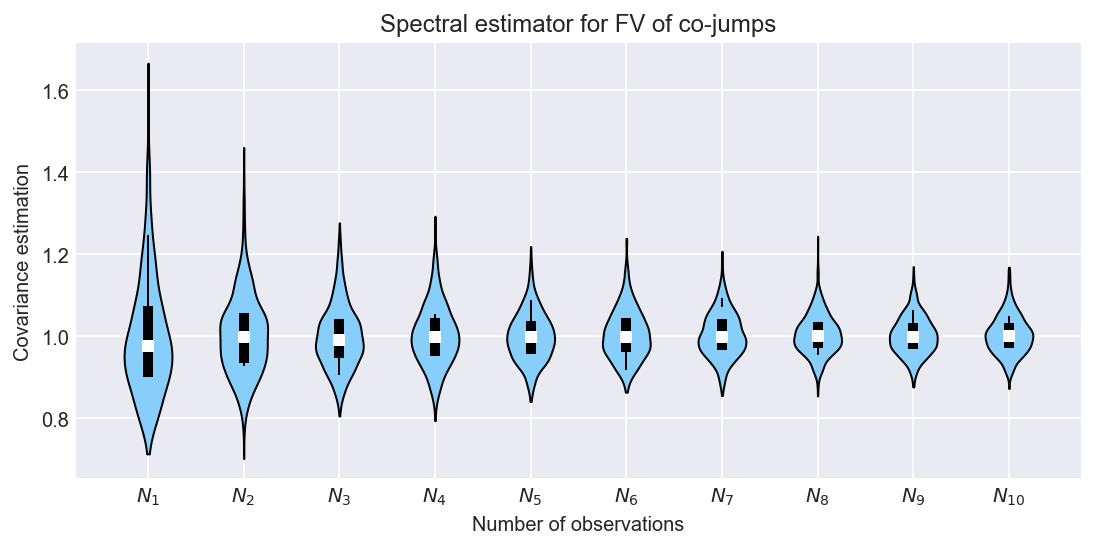

In [4]:
%config InlineBackend.figure_format = 'retina'
# violin plots 
df = pd.DataFrame(np.array(C_hat_data).reshape(10, n))

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(x, labels):
    x.get_xaxis().set_tick_params(direction='out')
    x.xaxis.set_ticks_position('bottom')
    x.set_xticks(np.arange(1, len(labels) + 1))
    x.set_xticklabels(labels)
    x.set_xlim(0.25, len(labels) + 0.75)
    x.set_xlabel('Number of observations')

fig, (x) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey = True)
x.set_title('Spectral estimator for FV of co-jumps')
parts = x.violinplot(
        C_hat_data, showmeans = False, showmedians = False,
        showextrema = False)

for pc in parts['bodies']:
    pc.set_facecolor('lightskyblue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(C_hat_data, [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(C_hat_data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
x.scatter(inds, medians, marker = 's', color = 'white', s = 30, zorder = 3)
x.vlines(inds, quartile1, quartile3, color = 'k', linestyle = '-', lw = 5)
x.vlines(inds, whiskersMin, whiskersMax, color = 'k', linestyle = '-', lw = 1)

# set style for the axes
labels = ['$N_{1}$', '$N_{2}$', '$N_{3}$', '$N_{4}$', '$N_{5}$', '$N_{6}$', '$N_{7}$', '$N_{8}$', '$N_{9}$', '$N_{10}$']
ylabel('Covariance estimation')
set_axis_style(x, labels)
plt.show()

In [6]:
# RMSE for the C_hat estimation in the case of finite variation of jumps
N = [x for x in range(1000, 10100, 1000)]
mse = []
vec = np.ones(n)
for i in range(len(N)):
    mean = mean_squared_error(C_hat_data[i], vec)
    mse.append(mean)
rmse = np.sqrt(mean)